### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob
import os

from datetime import datetime

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

from yellowbrick.cluster import KElbowVisualizer

from wordcloud import WordCloud
import re

In [4]:
pd.set_option('max_colwidth', 800)

### Functions

In [61]:
def clean_up(tweet):
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet.lower())
    tweet = re.sub('[\s]+', ' ', tweet)      #correct double white spaces to a single white space
    tweet = re.sub(r'\W*\b\w{1,3}\b', '', tweet)
    tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet)  #remove all ponctuation
    return tweet

def tokenize(tweet):
    return word_tokenize(tweet)

def stem_and_lemmatize(tweet):
    tweet = ' '.join(tweet)
    stem = PorterStemmer().stem(tweet)
    lemm = WordNetLemmatizer().lemmatize(stem)
    return lemm

def remove_stopwords(tweet):
    stop_words = set(stopwords.words('english')) 
    return [i for i in tweet.split() if i not in stop_words]

stopwords_dict = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}
#function to detect language based on # of stop words for particular language
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    lang = max(((lang, len(words & stopwords)) for lang, stopwords in stopwords_dict.items()), key = lambda x: x[1])[0]
    return True if lang == 'english'else False
    
def get_pm(row):
    pms = []
    text = row["text"].lower()
    if "boris" in text or "johnson" in text:
        pms.append("boris")
    elif "theresa" in text:
        pms.append("may")
    else:
        pms.append("none") 
    return ",".join(pms)

### Data

In [6]:
path = r'/Users/ironhack/Documents/GitHub/IronHack/W9FinalProject/final-project/your-project/tweets/2019' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))
list_of_files = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li_of_files, axis=0, ignore_index=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 15 columns):
username          250000 non-null object
to                151040 non-null object
text              249518 non-null object
retweets          250000 non-null int64
favorites         250000 non-null int64
replies           250000 non-null int64
id                250000 non-null int64
permalink         250000 non-null object
author_id         250000 non-null int64
date              250000 non-null object
formatted_date    250000 non-null object
hashtags          62830 non-null object
mentions          33182 non-null object
geo               0 non-null float64
urls              78961 non-null object
dtypes: float64(1), int64(5), object(9)
memory usage: 28.6+ MB


In [8]:
df.isna().sum()*100/len(df)

username            0.0000
to                 39.5840
text                0.1928
retweets            0.0000
favorites           0.0000
replies             0.0000
id                  0.0000
permalink           0.0000
author_id           0.0000
date                0.0000
formatted_date      0.0000
hashtags           74.8680
mentions           86.7272
geo               100.0000
urls               68.4156
dtype: float64

In [9]:
df.columns

Index(['username', 'to', 'text', 'retweets', 'favorites', 'replies', 'id',
       'permalink', 'author_id', 'date', 'formatted_date', 'hashtags',
       'mentions', 'geo', 'urls'],
      dtype='object')

In [10]:
df = df[['date','id', 'username', 'text']]

In [11]:
df.head()

,date,id,username,text
0,2019-07-30 23:59:58+00:00,1156353776049111040,janekin24,Not about Brexit for Boris. I see his strategy. It’s all about killing off TBP. Smokescreen of WTO hard talk.Then he will give us Brino. Well Twitter friends. Are we going to let him get away with this or will we take TBP all the way to government? We are not going into that box!
1,2019-07-30 23:59:58+00:00,1156353774262390785,brexit_clock,"WOW - Another Brexit extension - time now until 31st October 2019 : 92 days, 21 hours, 59 minutes and 59 seconds #BREXIT #BREXITCLOCK #CLOCK #EU #EUREF #LEAVE"
2,2019-07-30 23:59:50+00:00,1156353739437019136,JuanWild51,Brexit: Can Anyone Take the Wheel From Johnson?..#Bojo..#Brexit..#Britain..
3,2019-07-30 23:59:45+00:00,1156353717987368960,DGAll41,"Brexit minister Stephen Barclay tells Michel Barnier that UK will leave EU on October 31 with or without a deal - Evening Standard. Amazing Gove has just been bollocked for similar terminology and less than 24 hrs later, dick Barclay blunders in."
4,2019-07-30 23:59:44+00:00,1156353717232459776,BioMickWatson,This isn't a superhero movie where the bad guy gets to be a good guy because they share common cause. Brexit and Scottish indy *are* the common cause we need to fight against


In [12]:
df.dropna(inplace=True)

In [13]:
df.dtypes

date        object
id           int64
username    object
text        object
dtype: object

In [14]:
df.drop_duplicates(subset='id', inplace=True)

In [15]:
df.drop('id', inplace=True, axis=1)

In [16]:
df.shape

(244534, 3)

### Fixing time type column

In [17]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = [d.date() for d in df['date']]
df['month'] = pd.DatetimeIndex(df['date']).month

### Removing non english tweets

In [18]:
df['language'] = df['text'].apply(get_language)
df = df[(df['language'] == True)]
df.drop('language', inplace=True, axis=1)

### Creating column for Theresa May/Boris Jonhson - selecting tweets that only refer the PMs

In [19]:
df["pm"] = df.apply(get_pm,axis=1)

In [21]:
may_df = df[df['pm'] == 'may']
boris_df = df[df['pm'] == 'boris']
df_mb = may_df.append(boris_df)

### Remove user accounts that are related to news and trolls?

In [340]:
df1['username'].value_counts().sort_values(ascending=False).head(50)

AtlantoCeltica     427
brexit_politics    216
dddoc_blogger      162
BBCPropaganda      156
BrexitHome         135
Doozy_45           134
BrexitLondon       133
TimesEurope        119
brexit_fact        118
Orgetorix          116
MrDJones           114
JoseSaylor         111
JeanneBartram      107
SpartanEdgeX28     104
brexit_clock       103
BrexitMeans        101
AndrewKnight226     99
mojos55             98
SocialistVoice      93
UxbEconomist07      93
Brexit_Delusion     90
Rowland72James      90
HandsOffLondon      89
brexit_sham         88
brexit_talks        85
McEwanMorton        85
uk_domain_names     84
theelatestnews      84
JKLDNMAD            82
BrexitBetrayed      80
cassiemonoo         79
OutragedMary        77
love_brexit         76
andy_Brexit         74
jondknight          73
nickreeves9876      73
my_amigouk          72
Kilsally            71
bbcquestiontime     71
The_Theresa_A       71
what_brexit_is      70
Brexit_Support      70
localnotail         69
richbsys   

In [154]:
df.groupby('username')['username'].value_counts().sort_values(ascending=False)

username         username       
Rowland72James   Rowland72James     90
Brexit_Delusion  Brexit_Delusion    90
HandsOffLondon   HandsOffLondon     89
brexit_sham      brexit_sham        88
brexit_talks     brexit_talks       85
                                    ..
Suzannah_Baron   Suzannah_Baron      1
mike6031769      mike6031769         1
mike79mjw        mike79mjw           1
Suz_Abd          Suz_Abd             1
The_Moccasin_    The_Moccasin_       1
Name: username, Length: 93955, dtype: int64

In [150]:
df[df.username == 'TimesEurope']

,date,username,text,month,pm,test
17604,2019-03-12,TimesEurope,Brexit: Will the ERG become the villains of Brexit? Will Britain NEVER LEAVE the EU now? https://uk.timesofnews.com/breaking-news/brexit-will-the-erg-become-the-villains-of-brexit-will-britain-never-leave-the-eu-now,3,none,other
17690,2019-03-12,TimesEurope,‘The night you LOST BREXIT!’ Jacob Rees-Mogg STUNNED as Andrew Neil lets loose on ERG https://uk.timesofnews.com/breaking-news/the-night-you-lost-brexit-jacob-rees-mogg-stunned-as-andrew-neil-lets-loose-on-erg,3,none,other
17809,2019-03-12,TimesEurope,‘More than ever we need the European Council to ring-fence our rights’: Reactions to May’s Brexit defeat,3,none,other
25493,2019-10-12,TimesEurope,The Papers: Brexit bargain and ‘marathon miracle’ https://uk.timesofnews.com/breaking-news/the-papers-brexit-bargain-and-marathon-miracle,10,none,other
26115,2019-10-12,TimesEurope,DUP send PM huge Brexit warning amid betrayal fears – ‘Boris knows very well’ https://uk.timesofnews.com/breaking-news/dup-send-pm-huge-brexit-warning-amid-betrayal-fears-boris-knows-very-well,10,boris,other
...,...,...,...,...,...,...
216598,2019-10-28,TimesEurope,Brexit: PM to try again for 12 December election after MPs reject plan https://uk.timesofnews.com/breaking-news/brexit-pm-to-try-again-for-12-december-election-after-mps-reject-plan,10,none,other
216599,2019-10-28,TimesEurope,Farage demands Boris apologise for failing to meet Brexit deadline https://uk.timesofnews.com/breaking-news/farage-demands-boris-apologise-for-failing-to-meet-brexit-deadline,10,boris,other
216600,2019-10-28,TimesEurope,Brexit: PM to try again for 12 December election after MPs reject plan https://uk.timesofnews.com/breaking-news/brexit-pm-to-try-again-for-12-december-election-after-mps-reject-plan-2,10,none,other
216708,2019-10-28,TimesEurope,Brexit 50p coins to be ‘recycled’ after PM accepts extension https://uk.timesofnews.com/breaking-news/brexit-50p-coins-to-be-recycled-after-pm-accepts-extension-2,10,none,other


### Cleaning the tweets

In [64]:
df_mb['text_wturls'] = df_mb['text'].apply(clean_up)
df_mb['text_processed'] = df_mb['text'].apply(clean_up).apply(tokenize).apply(stem_and_lemmatize).apply(remove_stopwords)
df_mb['clean_text'] = [' '.join(map(str, l)) for l in df_mb['text_processed']]

may_df['text_wturls'] = may_df['text'].apply(clean_up)
may_df['text_processed'] = may_df['text'].apply(clean_up).apply(tokenize).apply(stem_and_lemmatize).apply(remove_stopwords)
may_df['clean_text'] = [' '.join(map(str, l)) for l in may_df['text_processed']]

boris_df['text_wturls'] = boris_df['text'].apply(clean_up)
boris_df['text_processed'] = boris_df['text'].apply(clean_up).apply(tokenize).apply(stem_and_lemmatize).apply(remove_stopwords)
boris_df['clean_text'] = [' '.join(map(str, l)) for l in boris_df['text_processed']]

/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ironhack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [65]:
df_mb

,date,month,text,text_wturls,text_processed,clean_text,pm,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment,sentiment_n
287,2019-07-30,7,"Theresa May was not highly rated by her colleagues or the civil service, even before she became PM. But on top of that, she supported Remain in the referendum. Therefore she always regarded #Brexit as a damage limitation exercise, rather than a golden opportunity for the UK.",theresa highly rated colleagues civil service even before became that supported remain referendum therefore always regarded brexit damage limitation exercise rather than golden opportunity,"[theresa, highly, rated, colleagues, civil, service, even, became, supported, remain, referendum, therefore, always, regarded, brexit, damage, limitation, exercise, rather, golden, opportun]",theresa highly rated colleagues civil service even became supported remain referendum therefore always regarded brexit damage limitation exercise rather golden opportun,may,-0.4767,0.700,0.210,0.089,negative,0
621,2019-07-30,7,Theresa May MP: Give People a Final Say on Brexit Deal - Sign the Petition! http://chng.it/V2hMq75D via @UKChange,theresa give people final brexit deal sign petition ukchange,"[theresa, give, people, final, brexit, deal, sign, petition, ukchang]",theresa give people final brexit deal sign petition ukchang,may,0.0000,1.000,0.000,0.000,neutral,1
1033,2019-07-30,7,Brexit Flextension Will Be Extended Forevextension in Permaextension Brexitstension https://www.dailysquib.co.uk/world/31578-brexit-flextension-will-be-extended-forevextension-in-permaextension-brexitstention.html #brexit #theresamay,brexit flextension will extended forevextension permaextension brexitstension brexit theresamay,"[brexit, flextension, extended, forevextension, permaextension, brexitstension, brexit, theresamay]",brexit flextension extended forevextension permaextension brexitstension brexit theresamay,may,0.0000,1.000,0.000,0.000,neutral,1
1110,2019-07-30,7,"#Brexit Delay #TheresaMay Consulted by Peter Mandelson, David Cameron &amp; Tony Blair https://www.dailysquib.co.uk/world/20666-theresa-may-consulted-peter-mandelson-david-cameron-tony-blair.html",brexit delay theresamay consulted peter mandelson david cameron tony blair,"[brexit, delay, theresamay, consulted, peter, mandelson, david, cameron, tony, blair]",brexit delay theresamay consulted peter mandelson david cameron tony blair,may,-0.3182,0.796,0.204,0.000,negative,0
1357,2019-07-30,7,Very interesting documentary last week describing how Theresa May came to realise the genuine threat to the Union caused by a no deal Brexit.,very interesting documentary last week describing theresa came realise genuine threat union caused deal brexit,"[interesting, documentary, last, week, describing, theresa, came, realise, genuine, threat, union, caused, deal, brexit]",interesting documentary last week describing theresa came realise genuine threat union caused deal brexit,may,-0.1779,0.663,0.188,0.149,negative,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249943,2020-02-12,2,"@BorisJohnson, racists, andfar right @Conservatives got #Brexit, because they want to close the borders and don't have a plan to protect the economy which will hurt the country. #BrexitRacism #DissolveTheUnion #BrexitShambles #BrexitLies #Antifascism #Antiracism #BorisTheLiar",borisjohnson racists andfar right conservatives brexit because they want close borders have plan protect economy which will hurt country brexitracism dissolvetheunion brexitshambles brexitlies antifascism antiracism boristheliar,"[borisjohnson, racists, andfar, right, conservatives, brexit, want, close, borders, plan, protect, economy, hurt, country, brexitracism, dissolvetheunion, brexitshambles, brexitlies, antifascism, antiracism, boristheliar]",borisjohnson racists andfar right conservatives brexit want close borders plan protect economy hurt country brexitracism dissolvetheunion brexitshambles brexitlies ant

In [32]:
df_mb = df_mb[['date', 'month','text','text_wturls','text_processed','clean_text','pm']]
may_df = may_df[['date', 'month','text','text_wturls','text_processed','clean_text','pm']]
boris_df = boris_df[['date', 'month','text','text_wturls','text_processed','clean_text','pm']]

In [24]:
df_mb.month.value_counts()

10    4255
3     4249
4     4102
7     3079
12    3016
8     2893
9     2228
1     1539
2     1455
6     1398
11    1203
5      830
Name: month, dtype: int64

In [ ]:
df_mb.groupby('mp')df_mb.month.value_counts()

### Checking top words

In [70]:
words = [w for row in df_mb['text_processed'] for w in row]
pos_count = FreqDist(words)
freq = pos_count.most_common(50)
df_freq = pd.DataFrame(freq, columns=['word', 'freq'])
df_freq.head(50)

,word,freq
0,brexit,26599
1,boris,12837
2,theresa,10296
3,johnson,10086
4,deal,6283
5,borisjohnson,3397
6,may,2560
7,party,2515
8,vote,2399
9,people,2188


## K-means

### Checking optimal number of clusters

In [225]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,17))
visualizer.fit(desc_matrix)
visualizer.poof()

NameError: name 'desc_matrix' is not defined

## Preparing & Implementing K-Means

### Vectorizing with CountVectorizer

In [ ]:
#vectorizing with CountVectorizer
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(df_mb["clean_text"])
desc_matrix = tf_idf_vect.transform(df_mb["clean_text"])

In [ ]:
#implementing kmeans
km = KMeans(n_clusters = 3, n_init = 10, n_jobs = -1)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [ ]:
df_mb['labels'] = clusters

### Vectorizing with TfidfVectorizer

#### Whole Dataset:

In [33]:
#vectorizing with TfidfVectorizer
tweets = [tweet for tweet in df_mb['clean_text']]
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))  
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)  
feature_names = tfidf_vectorizer.get_feature_names()  

In [ ]:
#implementing kmeans 
km = KMeans(n_clusters = 3, n_init = 10, n_jobs = -1)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [ ]:
df_mb['labels_tfid'] = clusters

#### May:

In [34]:
tweets = [tweet for tweet in may_df['clean_text']]
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))  
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)  
m_feature_names = tfidf_vectorizer.get_feature_names() 

#### Boris

In [37]:
tweets = [tweet for tweet in boris_df['clean_text']]
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))  
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)  
b_feature_names = tfidf_vectorizer.get_feature_names() 

#### Jan - June

#### June - Dec

In [ ]:
df_mb[df_mb['pm'] == 'may']['labels'].value_counts()

In [ ]:
df_mb[df_mb['pm'] == 'boris']['labels_tfid'].value_counts()

In [ ]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(3):
    print("Cluster {}: Words:".format(i))
    for ind in order_centroids[i, :10]: 
        print('    %s' % feature_names[ind])

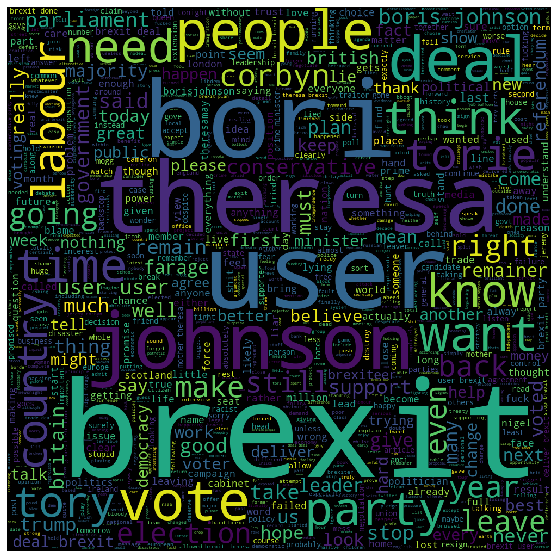

In [93]:
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(feature_names))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()

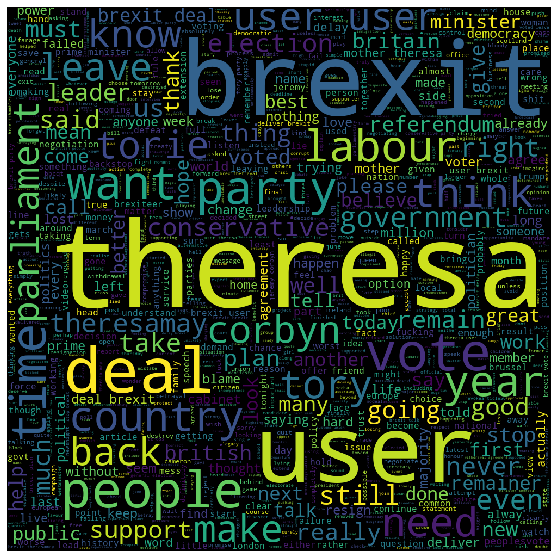

In [35]:
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(m_feature_names))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()

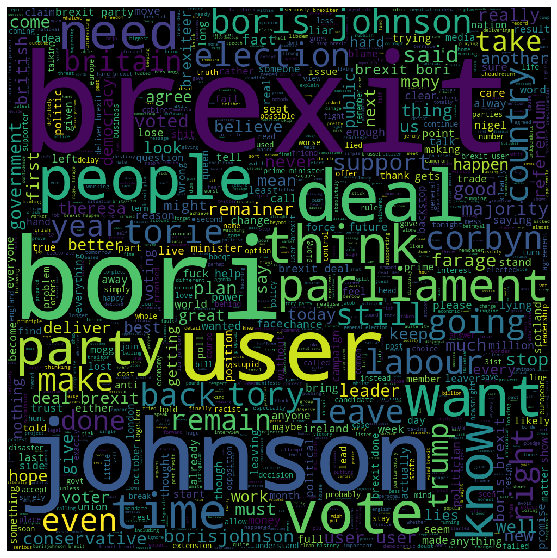

In [38]:
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(b_feature_names))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()

### Checking results

#### 3 iterations

In [ ]:
df_mb[df_mb['pm'] == 'may']['labels'].value_counts()

In [ ]:
df_mb[df_mb['pm'] == 'boris']['labels'].value_counts()

#### 10 iterations

In [ ]:
df_mb[df_mb['pm'] == 'may']['labels'].value_counts()

In [ ]:
df_mb[df_mb['pm'] == 'boris']['labels'].value_counts()

## Sentiment Analysis

### NLKT

In [ ]:
def sentiment_analyzer_scores(text):
    sid = SentimentIntensityAnalyzer()
    lb = sid['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

In [39]:
#with nlkt sentiment analysys
sid = SentimentIntensityAnalyzer()

df_mb['sentiment_compound_polarity'] = df_mb['clean_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_mb['sentiment_neutral'] = df_mb['clean_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
df_mb['sentiment_negative'] = df_mb['clean_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
df_mb['sentiment_pos'] = df_mb['clean_text'].apply(lambda x:sid.polarity_scores(x)['pos'])

df_mb.loc[df_mb.sentiment_compound_polarity > 0,'sentiment'] = 'positive'
df_mb.loc[df_mb.sentiment_compound_polarity == 0,'sentiment'] = 'neutral'
df_mb.loc[df_mb.sentiment_compound_polarity < 0,'sentiment'] = 'negative'
df_mb.head()

,date,month,text,text_wturls,text_processed,clean_text,pm,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment
287,2019-07-30,7,"Theresa May was not highly rated by her colleagues or the civil service, even before she became PM. But on top of that, she supported Remain in the referendum. Therefore she always regarded #Brexit as a damage limitation exercise, rather than a golden opportunity for the UK.",Theresa highly rated colleagues civil service even before became that supported Remain referendum Therefore always regarded Brexit damage limitation exercise rather than golden opportunity,"[theresa, highly, rated, colleagues, civil, service, even, became, supported, remain, referendum, therefore, always, regarded, brexit, damage, limitation, exercise, rather, golden, opportun]",theresa highly rated colleagues civil service even became supported remain referendum therefore always regarded brexit damage limitation exercise rather golden opportun,may,-0.4767,0.700,0.210,0.089,negative
621,2019-07-30,7,Theresa May MP: Give People a Final Say on Brexit Deal - Sign the Petition! http://chng.it/V2hMq75D via @UKChange,Theresa Give People Final Brexit Deal Sign Petition AT USER,"[theresa, give, people, final, brexit, deal, sign, petition, us]",theresa give people final brexit deal sign petition us,may,0.0000,1.000,0.000,0.000,neutral
1033,2019-07-30,7,Brexit Flextension Will Be Extended Forevextension in Permaextension Brexitstension https://www.dailysquib.co.uk/world/31578-brexit-flextension-will-be-extended-forevextension-in-permaextension-brexitstention.html #brexit #theresamay,Brexit Flextension Will Extended Forevextension Permaextension Brexitstension brexit theresamay,"[brexit, flextension, extended, forevextension, permaextension, brexitstension, brexit, theresamay]",brexit flextension extended forevextension permaextension brexitstension brexit theresamay,may,0.0000,1.000,0.000,0.000,neutral
1110,2019-07-30,7,"#Brexit Delay #TheresaMay Consulted by Peter Mandelson, David Cameron &amp; Tony Blair https://www.dailysquib.co.uk/world/20666-theresa-may-consulted-peter-mandelson-david-cameron-tony-blair.html",Brexit Delay TheresaMay Consulted Peter Mandelson David Cameron Tony Blair,"[brexit, delay, theresamay, consulted, peter, mandelson, david, cameron, tony, blair]",brexit delay theresamay consulted peter mandelson david cameron tony blair,may,-0.3182,0.796,0.204,0.000,negative
1357,2019-07-30,7,Very interesting documentary last week describing how Theresa May came to realise the genuine threat to the Union caused by a no deal Brexit.,Very interesting documentary last week describing Theresa came realise genuine threat Union caused deal Brexit,"[interesting, documentary, last, week, describing, theresa, came, realise, genuine, threat, union, caused, deal, brexit]",interesting documentary last week describing theresa came realise genuine threat union caused deal brexit,may,-0.1779,0.663,0.188,0.149,negative


In [ ]:
#df_mb.drop(['sentiment_polarity', 'sentiment_type','sentiment_neutral', 'sentiment_negative', 'sentiment_pos', 'sentiment_compound_polarity'], axis=1, inplace=True)

In [400]:
df_mb.groupby('pm')['sentiment'].value_counts()

pm     sentiment
boris  positive     8585
       negative     8204
       neutral      3506
may    positive     4186
       negative     3654
       neutral      1886
Name: sentiment, dtype: int64

## Visualization

In [40]:
df_mb['sentiment_n'] = df_mb['sentiment'].apply(
      lambda x: 2 if x == 'positive' else (0 if x == 'negative' else 1))

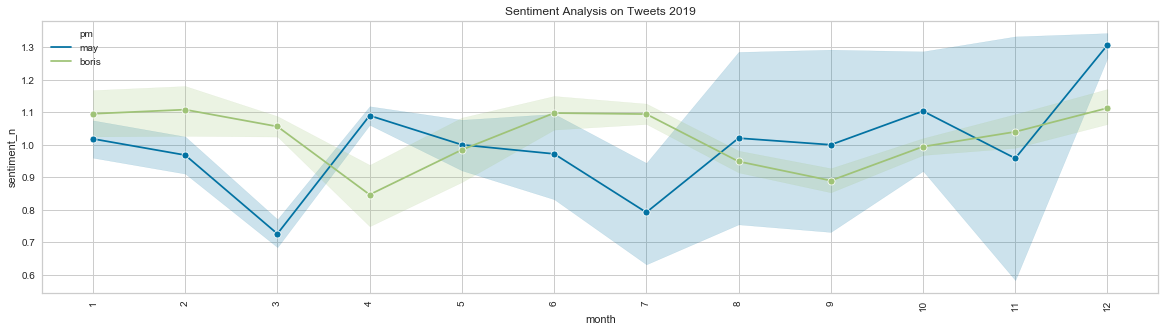

In [41]:
plt.figure(figsize=(20,5)) # Figure size
sns.lineplot(x='month', y='sentiment_n', data=df_mb, hue='pm', marker='o')
plt.title('Sentiment Analysis on Tweets 2019')
plt.xticks(df_mb.month.unique(), rotation=90) 
plt.show()